In [14]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2

import sys 
sys.path.append('..')
from models import SoftmaxWeight,SoftmaxWeightOver,DIFDensityEstimator, MixedModelDensityEstimator, RealNVPDensityEstimatorLayer, MultivariateNormalReference, EMDensityEstimator
from utils.color_visual import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(256, 197, 3)


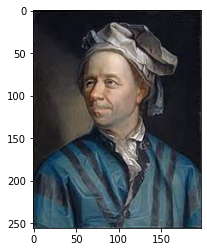

In [3]:
rgb = image.imread("euler.jpg")
plt.imshow(rgb)
print(rgb.shape)

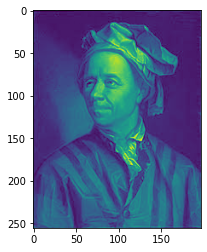

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = rgb2gray(rgb)
plt.imshow(torch.tensor(grey))

In [5]:
vector_density = torch.tensor(grey).flatten()
vector_density = vector_density/torch.sum(vector_density)

In [89]:
lignes, colonnes = grey.shape
num_samples = 100000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + 0.01*torch.randn([num_samples,2])

<ipython-input-89-dd9cf1590b3d>:5: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + 0.01*torch.randn([num_samples,2])


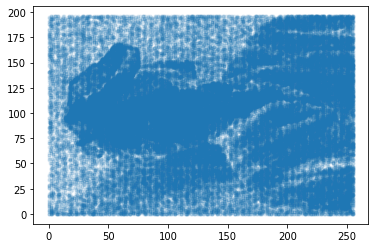

In [90]:
plt.scatter(target_samples[:,0], target_samples[:, 1], alpha = .1, marker = '.')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [06:21<00:00,  1.91s/it, loss = 10.614632606506348]
C:\Users\Elouan\PycharmProjects\Discretely-Indexed-Flows\venv\lib\site-packages\seaborn\_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

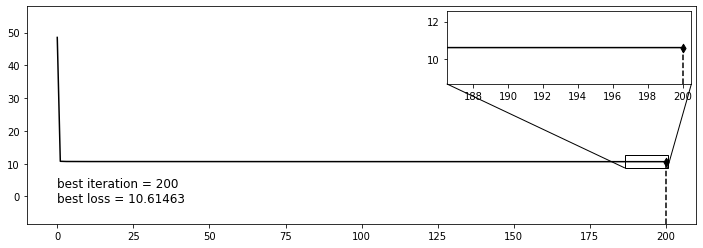

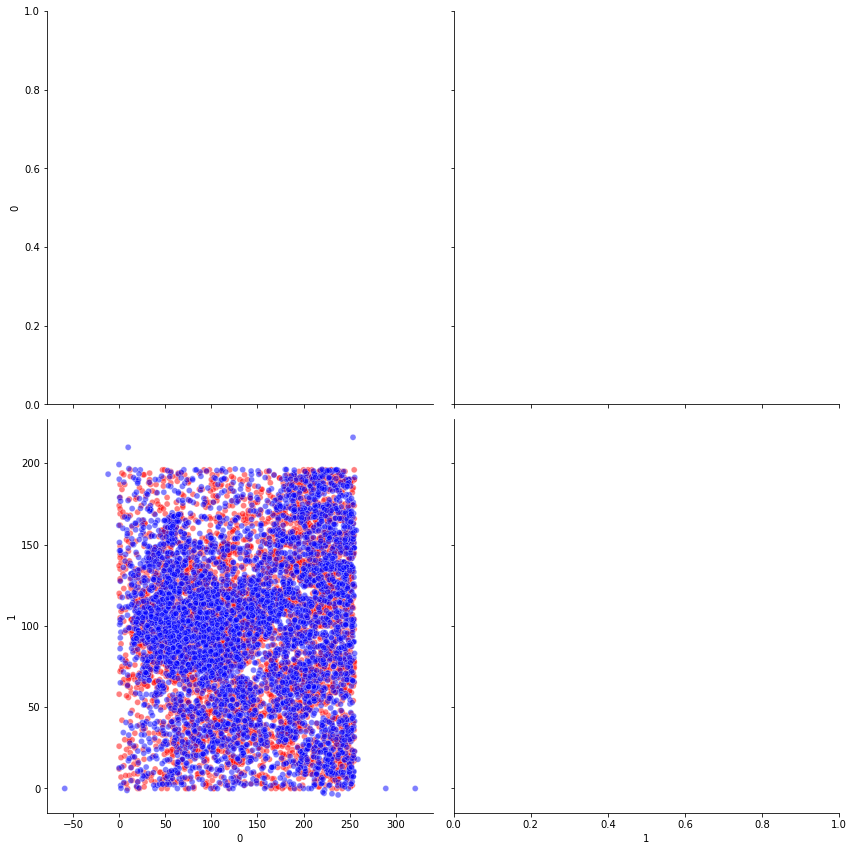

In [91]:
num_samples = target_samples.shape[0]
epochs = 200
K = 200
EM = EMDensityEstimator(target_samples,K)
loss_values = EM.train(epochs,visual=True)
EM.model_visual()

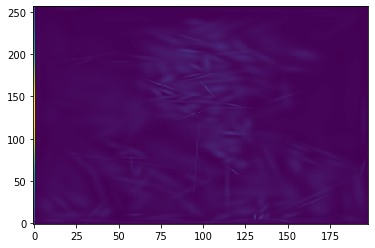

In [84]:
delta = 300
grid = torch.cartesian_prod(torch.linspace(0, lignes,lignes),torch.linspace(0, colonnes, colonnes))
density = torch.exp(EM.log_density(grid)).reshape(lignes,colonnes).T.cpu().detach()
plt.pcolormesh(torch.linspace(0,colonnes ,colonnes),torch.linspace(0, lignes, lignes), torch.flip(torch.flip(density.T,[0,1]),[1]))

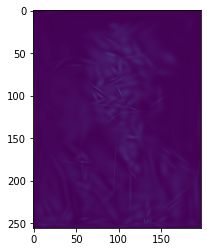

In [85]:
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]))

In [45]:
density.shape

torch.Size([300, 300])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [42:05<00:00, 25.25s/it, loss = 10.408146858215332]
C:\Users\Elouan\PycharmProjects\Discretely-Indexed-Flows\venv\lib\site-packages\seaborn\_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

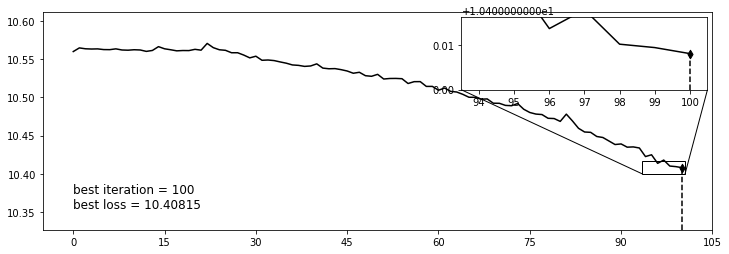

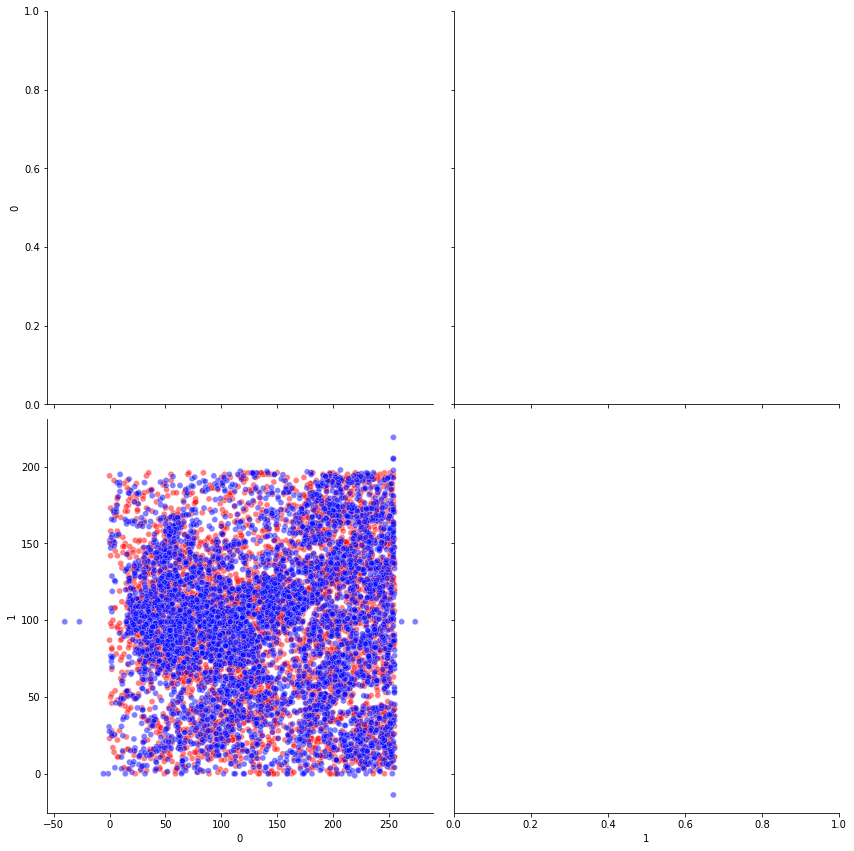

In [86]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 100
batch_size = 1000
initial_T = EM.T
initial_w = SoftmaxWeightOver(K, 2, [64,64,64], mode = 'NN')
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K, 64))
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w)
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()

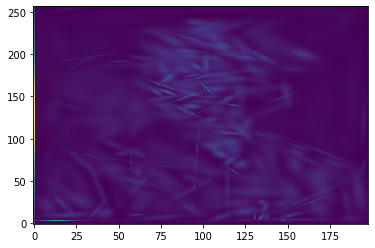

In [87]:
delta = 300
grid = torch.cartesian_prod(torch.linspace(0, lignes,lignes),torch.linspace(0, colonnes, colonnes))
density = torch.exp(EM.log_density(grid)).reshape(lignes,colonnes).T.cpu().detach()
plt.pcolormesh(torch.linspace(0,colonnes ,colonnes),torch.linspace(0, lignes, lignes), torch.flip(torch.flip(density.T,[0,1]),[1]))

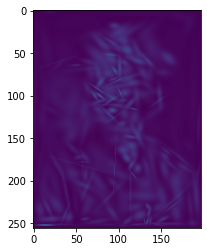

In [88]:
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]))